The goal of this notebook is to use the pretrained RoBERTa base transformer for finetuning on a hate speech dataset to determine a baseline for the costum classification heads to beat. 

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, TrainingArguments, Trainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt

import sys
from pathlib import Path

# Add src/ to path (once, so imports work)
sys.path.append(str(Path().resolve().parent / "src"))

%load_ext autoreload
%autoreload 2
from helper_functions import HateSpeechDataset
from helper_functions import get_class_distribution, oversample_dataset, undersample_dataset

2025-05-16 16:22:07.101526: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 16:22:07.117459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747405327.136515   82498 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747405327.142311   82498 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747405327.157071   82498 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
from paths import DATA_CLEANED, DATA_PROCESSED
print("Cleaned data path:", DATA_CLEANED)
print("Processed data path:", DATA_PROCESSED)

Cleaned data path: /Project/data/cleaned
Processed data path: /Project/data/processed


In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Finetuning RoBERTa base

Define which pretrained model is used and initilise tokenizer

In [4]:
model_name = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)

### Load HASOC dataset for training, validation and testing

Define experiment scope:

In [5]:
# here we are just using the labels of the first task of the HASOC dataset, which is a binary classification
label = "task_1"

In [6]:
# Load training and test data
clean_df = pd.read_csv(DATA_CLEANED / "hasoc_2019_en_train_cleaned.tsv", sep='\t')
# test_df = pd.read_csv(DATA_PROCESSED / "hasoc_2019_en_test.tsv", sep='\t')
test_df = pd.read_csv(DATA_CLEANED / "hasoc_2019_en_test_cleaned.tsv", sep='\t')

# Split clean dataset in training and validation set
train_df, val_df = train_test_split(clean_df, test_size=0.3, random_state=42, stratify=clean_df[label])

# Automatically map string labels to integers
label_list = sorted(train_df[label].unique())
label_map = {label: idx for idx, label in enumerate(label_list)}

train_df[label] = train_df[label].map(label_map)
val_df[label] = val_df[label].map(label_map)
test_df[label] = test_df[label].map(label_map)

In [7]:
# Create PyTorch Datasets and DataLoaders
train_dataset = HateSpeechDataset(train_df, tokenizer, label=label)
val_dataset = HateSpeechDataset(val_df, tokenizer, label=label)
test_dataset = HateSpeechDataset(test_df, tokenizer, label=label)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=32)

print(get_class_distribution(train_df, label))

{1: 2513, 0: 1583}


### Training and evaluation of model

In [8]:
# Initialize model
num_labels = len(label_list)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Set learning rate
learning_rate = 2e-5

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=50,
    learning_rate=learning_rate,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=[],  # <- no logging to wandb
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [10]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.620900,0.596256,0.686219,0.711307,0.822820,0.763011
2,0.550000,0.589187,0.700456,0.701166,0.892393,0.785306
3,0.476200,0.619807,0.699886,0.723077,0.828386,0.772157
4,0.285100,0.727896,0.684510,0.738182,0.753247,0.745638
5,0.293500,0.841629,0.682232,0.739411,0.744898,0.742144


TrainOutput(global_step=1280, training_loss=0.4662163115106523, metrics={'train_runtime': 219.6736, 'train_samples_per_second': 93.229, 'train_steps_per_second': 5.827, 'total_flos': 1347128603443200.0, 'train_loss': 0.4662163115106523, 'epoch': 5.0})

### Testing of model

In [11]:
metrics = trainer.evaluate(eval_dataset=test_dataset)

In [12]:
predictions = trainer.predict(test_dataset)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)

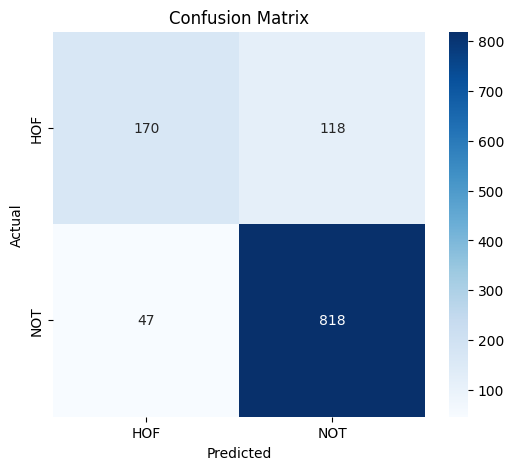

In [13]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
print(metrics)

{'eval_loss': 0.398926705121994, 'eval_accuracy': 0.8568950563746748, 'eval_precision': 0.8739316239316239, 'eval_recall': 0.945664739884393, 'eval_f1': 0.9083842309827873, 'eval_runtime': 2.7528, 'eval_samples_per_second': 418.841, 'eval_steps_per_second': 26.518, 'epoch': 5.0}


## Finetuning twitter RoBERTa base sentiment latest

Found this pretrained model online: cardiffnlp/twitter-roberta-base-sentiment-latest (https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest)

It is already pretrained on twitter messages. 

Define which pretrained model is used and initilise tokenizer

In [15]:
model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

tokenizer = AutoTokenizer.from_pretrained(model_name)

### Load HASOC dataset for training, validation and testing

Define experiment scope:

In [16]:
# here we are just using the labels of the first task of the HASOC dataset, which is a binary classification
label = "task_1"

In [17]:
# Load training and test data
clean_df = pd.read_csv(DATA_CLEANED / "hasoc_2019_en_train_cleaned.tsv", sep='\t')
# test_df = pd.read_csv(DATA_PROCESSED / "hasoc_2019_en_test.tsv", sep='\t')
test_df = pd.read_csv(DATA_CLEANED / "hasoc_2019_en_test_cleaned.tsv", sep='\t')

# Split clean dataset in training and validation set
train_df, val_df = train_test_split(clean_df, test_size=0.3, random_state=42, stratify=clean_df[label])

# Automatically map string labels to integers
label_list = sorted(train_df[label].unique())
label_map = {label: idx for idx, label in enumerate(label_list)}

train_df[label] = train_df[label].map(label_map)
val_df[label] = val_df[label].map(label_map)
test_df[label] = test_df[label].map(label_map)

In [18]:
# Create PyTorch Datasets and DataLoaders
train_dataset = HateSpeechDataset(train_df, tokenizer, label=label)
val_dataset = HateSpeechDataset(val_df, tokenizer, label=label)
test_dataset = HateSpeechDataset(test_df, tokenizer, label=label)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=32)

print(get_class_distribution(train_df, label))

{1: 2513, 0: 1583}


### Training and evaluation of model

In [19]:
# Initialize model
num_labels = len(label_list)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

# Set learning rate
learning_rate = 2e-5

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpo

In [20]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=50,
    learning_rate=learning_rate,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to=[],  # <- no logging to wandb
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds),
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.582900,0.577705,0.707859,0.712246,0.879406,0.787049
2,0.494300,0.616960,0.703872,0.745167,0.786642,0.765343
3,0.414400,0.645327,0.699317,0.725041,0.821892,0.770435
4,0.232500,0.857011,0.689066,0.732517,0.777365,0.754275
5,0.198800,1.042532,0.684510,0.736462,0.756957,0.746569


TrainOutput(global_step=1280, training_loss=0.41753106052055955, metrics={'train_runtime': 220.1183, 'train_samples_per_second': 93.041, 'train_steps_per_second': 5.815, 'total_flos': 1347128603443200.0, 'train_loss': 0.41753106052055955, 'epoch': 5.0})

### Testing of model

In [22]:
metrics = trainer.evaluate(eval_dataset=test_dataset)

In [23]:
predictions = trainer.predict(test_dataset)

preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)

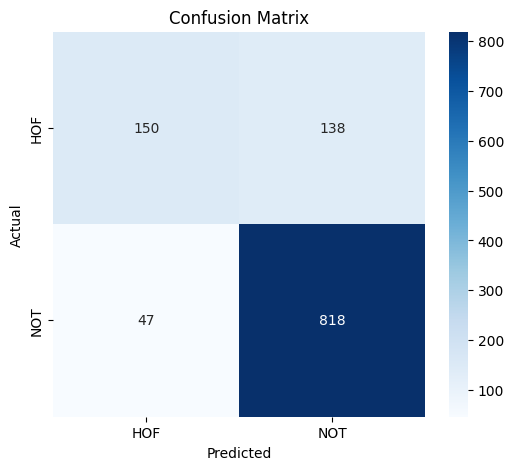

In [24]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [25]:
print(metrics)

{'eval_loss': 0.4008227288722992, 'eval_accuracy': 0.839549002601908, 'eval_precision': 0.8556485355648535, 'eval_recall': 0.945664739884393, 'eval_f1': 0.8984074684239429, 'eval_runtime': 2.7237, 'eval_samples_per_second': 423.314, 'eval_steps_per_second': 26.801, 'epoch': 5.0}
